**Setup** <br>
Run the code bellow to set up the necessary packages and download the data


In [14]:
!pip install -q pandas 
!pip install -q scikit-learn
!pip install -q numpy 
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q recordlinkage

import sys
sys.path.append("/home/sc.uni-leipzig.de/ci72buri/.local/lib/python3.12/site-packages") 
#Replace with your packet location

import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statistics import mean, median
import re
import unicodedata
import recordlinkage
from collections import defaultdict

In [15]:
class PhoneticAlgorithmsES:
    """
    Minimal but practical Spanish‑Metaphone encoder.
    It strips accents, normalises digraphs (ch, ll, rr, qu, ...)
    and applies a few Spanish‑specific sound–alike reductions.
    """

    _VOWELS = "aeiou"

    @staticmethod
    def _strip_accents(text: str) -> str:
        text = unicodedata.normalize("NFKD", text)
        return "".join(c for c in text if not unicodedata.combining(c))

    def spanish_metaphone(self, word: str) -> str:
        if not isinstance(word, str):
            return ""

        # 1. lower‑case & strip accents/punctuation
        w = self._strip_accents(word.lower())
        w = re.sub(r"[^\w]", "", w)

        # 2. drop starting silent h
        w = re.sub(r"^h", "", w)

        # 3. canonicalise common digraphs
        w = w.replace("ll", "y")     # llave → yave
        w = w.replace("ch", "x")     # chico → xico
        w = w.replace("rr", "r")     # carro → caro (metaphone normally collapses doubled consonants)
        w = w.replace("qu", "k")     # queso → k
        w = w.replace("gu", "g")     # guerra → gerra
        w = w.replace("v",  "b")     # v/b merge in Spanish

        # 4. context‑sensitive c/z/s → s
        w = re.sub(r"c([ei])", r"s\1", w)   # c + e/i has /s/ sound
        w = w.replace("z", "s")
        w = w.replace("c", "k")             # remaining c sounds like k

        # 5. ñ → n
        w = w.replace("ñ", "n")

        # 6. collapse repeated letters (aa → a, bb → b, ...)
        w = re.sub(r"(.)\1+", r"\1", w)

        # 7. drop trailing vowels except if the word is only one letter
        if len(w) > 1 and w[-1] in self._VOWELS:
            w = w[:-1]

        return w.upper()

In [16]:
class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, item):
        if item not in self.parent:
            self.parent[item] = item
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]

    def union(self, a, b):
        rootA = self.find(a)
        rootB = self.find(b)
        if rootA != rootB:
            self.parent[rootB] = rootA

def merge_groups(groups_dict):
    uf = UnionFind()
    # Union all values in the same group
    for key, group in groups_dict.items():
        group = list(group)
        for i in range(1, len(group)):
            uf.union(group[0], group[i])

    clusters = defaultdict(set)
    for key in uf.parent.keys():
        root = uf.find(key)
        clusters[root].add(key)

    return {k: sorted(v) for k, v in clusters.items()}

def map_to_group(value, group_dict):
    for key, group in group_dict.items():
        if value in group:
            return key
    return value  # if not found, keep original

In [17]:
#---------------------------------------------------------Functions-----------------------------------------------------------------------------
def group_rare_categories(df, threshold=0.01, columns=None, placeholder="other"):
    """
    Ersetzt seltene Kategorien (< threshold Anteil) durch einen Platzhalterwert.
    
    Args:
        df: Pandas DataFrame
        threshold: minimale Häufigkeit (relativ) – z.B. 0.01 = 1%
        columns: Liste von Spaltennamen (falls None: alle object/categorical)
        placeholder: Wert, der anstelle seltener Kategorien eingesetzt wird
        
    Returns:
        DataFrame mit ersetzten Kategorien
    """
    df_copy = df.copy()
    n_rows = len(df_copy)
    
    if columns is None:
        columns = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in columns:
        freqs = df_copy[col].value_counts(normalize=True)
        rare_values = freqs[freqs < threshold].index
        df_copy[col] = df_copy[col].apply(lambda x: placeholder if x in rare_values else x)
    
    return df_copy
#-------------------------------------------------------------------------------------------------------------------------------------------------
def compute_entropy(series):
    probs = series.value_counts(normalize=True, dropna=False)
    return -np.sum(probs * np.log2(probs + 1e-9))  # add small value to avoid log(0)
#-------------------------------------------------------------------------------------------------------------------------------------------------
def muy_limpio(s: str) -> str:
    if pd.isna(s):
        return ""
    # strip leading/trailing space, lowercase
    s = s.strip().lower()
    # normalise «áéíóúñ» → «aeioun»
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))  # drop accents
    # kill punctuation
    return re.sub(r"[^\w\s]", "", s)



**Introduction** <br>
This project works with a health dataset. The evaluation is done blind meaning that features will be chosen based on the statistics of the columns. The goal of this task is to a build a data classifier that is able to predict wheter someone will be classified with diabetes or not.


In [18]:
df = pd.read_csv("adultos_ensanut2023_w_n.csv", sep=";")


**Data Exploration & Cleaning**





In [19]:
print('---General Information about the dataset---')
print(f"Shape of the dataset: {df.shape}")
dtype_counts = df.dtypes.value_counts()
print(f"Data types \n{dtype_counts}")
#Dataset dominated by object features (presumably Strings) and some numeric data

---General Information about the dataset---
Shape of the dataset: (5569, 758)
Data types 
object     675
int64       75
float64      8
Name: count, dtype: int64


***Missing values***


In [20]:
print('\n---Na values in the dataset---')
na_counts = df.isna().sum()
print(f"Number of columns without entry: {len(na_counts[na_counts > 0])}")
print(f"Max na count: {max(na_counts)}")
print(f"Mean na count: {mean(na_counts)}")
print(f"Median na count: {median(na_counts)}")
#There are some missing values but the majority of features is complete


---Na values in the dataset---
Number of columns without entry: 159
Max na count: 1
Mean na count: 0.20976253298153033
Median na count: 0.0


***Empty strings***

In [21]:
print('\n---Empty strings in the dataset')
empty_str_counts = (df == '').sum()
print(f"Number of columns with empty strings: {(empty_str_counts > 0).sum()}")
print(f"Max empty string count: {empty_str_counts.max()}")
print(f"Mean empty string count: {empty_str_counts.mean()}")
print(f"Median empty string count: {empty_str_counts.median()}")
#No empty strings



---Empty strings in the dataset
Number of columns with empty strings: 0
Max empty string count: 0
Mean empty string count: 0.0
Median empty string count: 0.0


***Categorical data***


Unique value statistics for the categorical data


--- Summary statistics of unique value counts (string columns) ---
Min:    1
Max:    5569
Mean:   63.01
Median: 4.0
Std:    503.85

Quantiles:
0.25       3.00
0.50       4.00
0.75      10.00
0.90      26.00
0.95      53.80
0.99    1260.62
dtype: float64


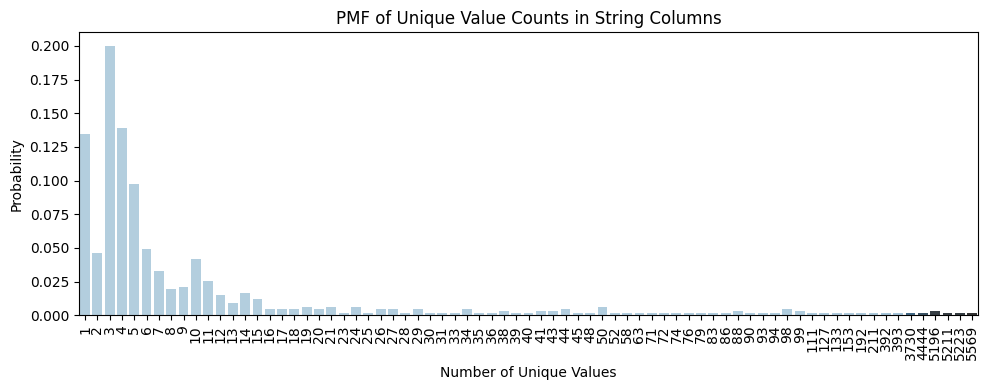

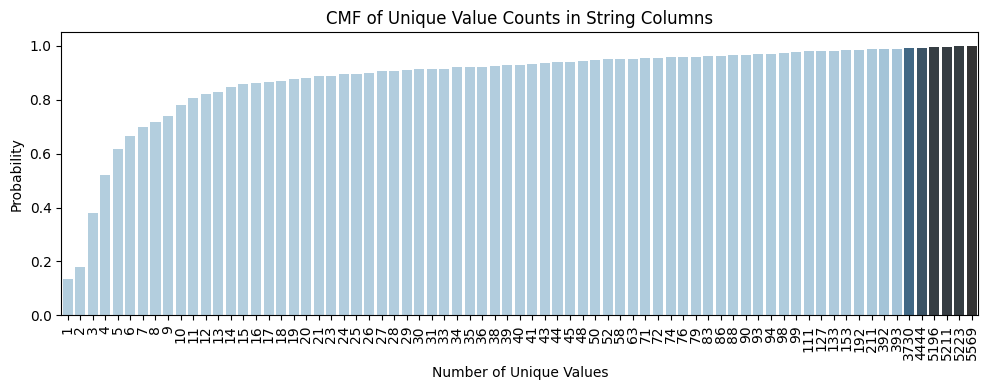

In [22]:
print("\n--- Summary statistics of unique value counts (string columns) ---")
# Select string columns
string_cols = df.select_dtypes(include=['object', 'category'])

# Count unique values per column
unique_counts = string_cols.nunique(dropna=False).sort_values()
print(f"Min:    {unique_counts.min()}")
print(f"Max:    {unique_counts.max()}")
print(f"Mean:   {unique_counts.mean():.2f}")
print(f"Median: {unique_counts.median()}")
print(f"Std:    {unique_counts.std():.2f}")

quantiles = unique_counts.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nQuantiles:")
print(quantiles)

# PMF: frequency of unique counts
pmf = unique_counts.value_counts(normalize=True).sort_index()

# CMF: cumulative probability
cmf = pmf.cumsum()

# --- Plot PMF ---
plt.figure(figsize=(10, 4))
sns.barplot(x=pmf.index, y=pmf.values, hue=pmf.index, palette="Blues_d", legend=False)
plt.title("PMF of Unique Value Counts in String Columns")
plt.xlabel("Number of Unique Values")
plt.ylabel("Probability")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Plot CMF ---
plt.figure(figsize=(10, 4))
sns.barplot(x=cmf.index, y=cmf.values, hue=cmf.index, palette="Blues_d", legend=False)
plt.title("CMF of Unique Value Counts in String Columns")
plt.xlabel("Number of Unique Values")
plt.ylabel("Probability")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Entropy of the categorical data


---Entropy of categorical (string) columns---
Min:    -1.4426951595367387e-09
Max:    12.443194542950705
Mean:   0.65
Median: 0.274096166799631
Std:    1.44

Quantiles:
0.25    0.027326
0.50    0.274096
0.75    0.784722
0.90    1.277250
0.95    1.894392
0.99    8.689685
dtype: float64


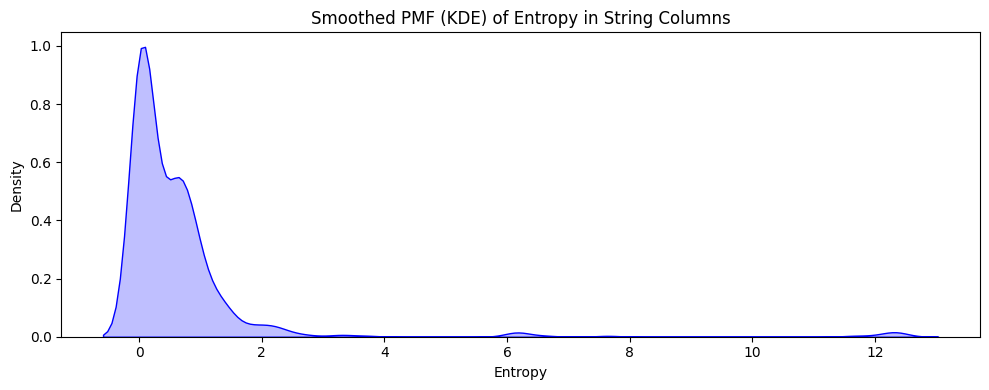

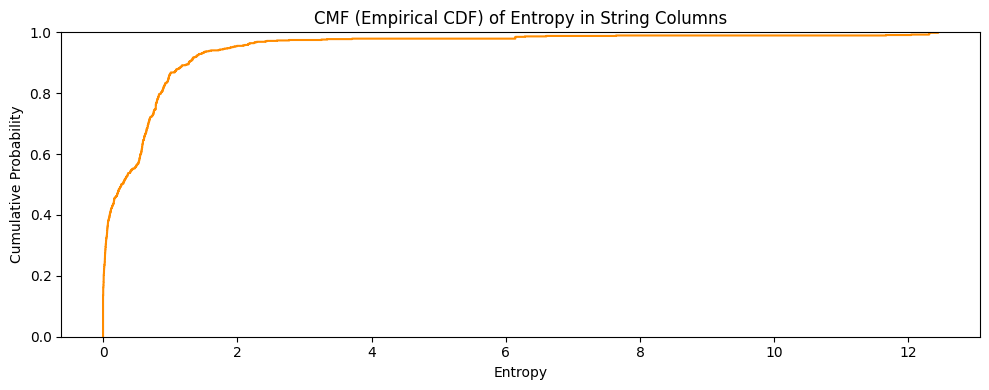

In [24]:
print("\n---Entropy of categorical (string) columns---")
# Compute entropy per column
entropy_values = string_cols.apply(compute_entropy).sort_values(ascending=False)

# Display
print(f"Min:    {entropy_values.min()}")
print(f"Max:    {entropy_values.max()}")
print(f"Mean:   {entropy_values.mean():.2f}")
print(f"Median: {entropy_values.median()}")
print(f"Std:    {entropy_values.std():.2f}")

quantiles = entropy_values.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nQuantiles:")
print(quantiles)

# Convert to Series if not already
entropy_series = pd.Series(entropy_values)

# Calculate PMF: frequency normalized
pmf = entropy_series.value_counts(normalize=True).sort_index()

# Calculate CMF: cumulative sum of PMF
cmf = pmf.cumsum()

# Assume entropy_values is a pandas Series or list

# --- Continuous PMF approximation using KDE ---
plt.figure(figsize=(10, 4))
sns.kdeplot(entropy_values, bw_adjust=0.5, fill=True, color="blue")
plt.title("Smoothed PMF (KDE) of Entropy in String Columns")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# --- Continuous CMF plot (Empirical CDF) ---
plt.figure(figsize=(10, 4))
sns.ecdfplot(entropy_values, color="darkorange")
plt.title("CMF (Empirical CDF) of Entropy in String Columns")
plt.xlabel("Entropy")
plt.ylabel("Cumulative Probability")
plt.tight_layout()
plt.show()

***Numerical Data***

Numerical feature statistics

In [25]:
numerical_df = df.select_dtypes(include=['number'])
print(sorted(numerical_df.nunique()))



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 7, 7, 7, 10, 12, 13, 23, 25, 49, 60, 73, 77, 77, 161, 165, 4909]



---Entropy of number columns---
Min:    -1.4426951595367387e-09
Max:    12.194363680597236
Mean:   1.15
Median: 0.5758284695446063
Std:    1.92

Quantiles:
0.25    0.002493
0.50    0.575828
0.75    1.289464
0.90    3.413927
0.95    5.146034
0.99    7.059621
dtype: float64


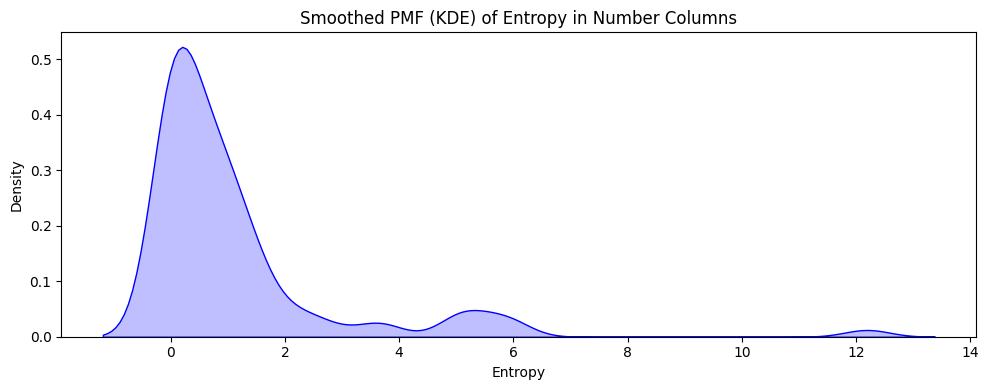

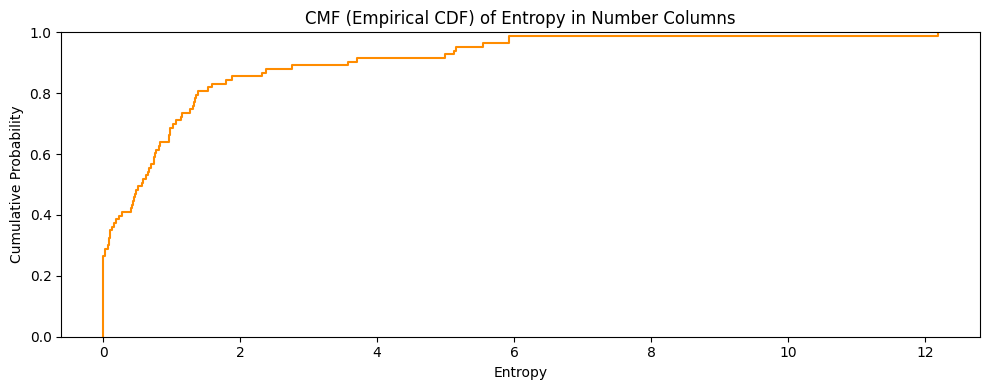

In [26]:
print("\n---Entropy of number columns---")
# Compute entropy per column
entropy_values = numerical_df.apply(compute_entropy).sort_values(ascending=False)

# Display
print(f"Min:    {entropy_values.min()}")
print(f"Max:    {entropy_values.max()}")
print(f"Mean:   {entropy_values.mean():.2f}")
print(f"Median: {entropy_values.median()}")
print(f"Std:    {entropy_values.std():.2f}")

quantiles = entropy_values.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nQuantiles:")
print(quantiles)

# Convert to Series if not already
entropy_series = pd.Series(entropy_values)

# Calculate PMF: frequency normalized
pmf = entropy_series.value_counts(normalize=True).sort_index()

# Calculate CMF: cumulative sum of PMF
cmf = pmf.cumsum()

# Assume entropy_values is a pandas Series or list

# --- Continuous PMF approximation using KDE ---
plt.figure(figsize=(10, 4))
sns.kdeplot(entropy_values, bw_adjust=0.5, fill=True, color="blue")
plt.title("Smoothed PMF (KDE) of Entropy in Number Columns")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# --- Continuous CMF plot (Empirical CDF) ---
plt.figure(figsize=(10, 4))
sns.ecdfplot(entropy_values, color="darkorange")
plt.title("CMF (Empirical CDF) of Entropy in Number Columns")
plt.xlabel("Entropy")
plt.ylabel("Cumulative Probability")
plt.tight_layout()
plt.show()

***Investigate flaot vlaues (assumed to be true numerical values)***

In [ ]:
float_values = df

**Data Cleaning**

***Numeric_values***

Fill missing randoms with the column mean based on the assumption that the values are missing at random

In [27]:
df = df.fillna(df.mean(numeric_only=True))

***Drop if there is only one unqiue value in the column in the dataframe***

In [28]:
df = df.loc[:, df.nunique(dropna=False) > 1]

***Split into int(categorical) and float***

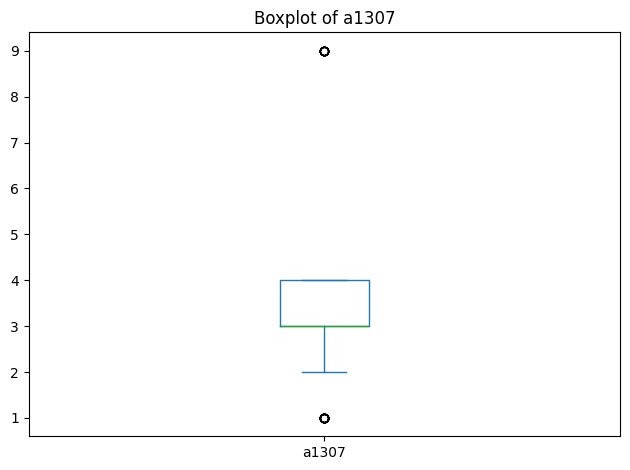

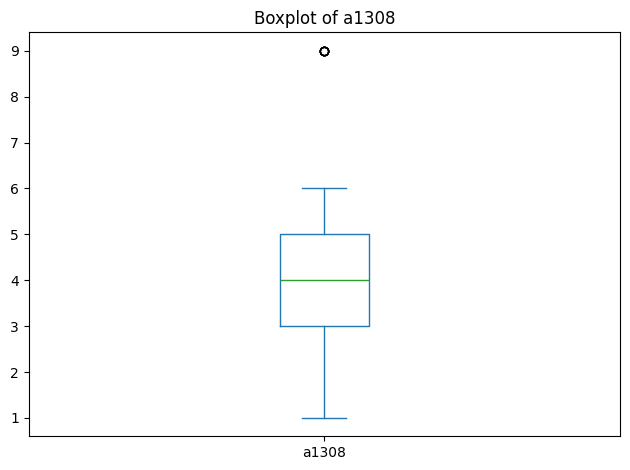

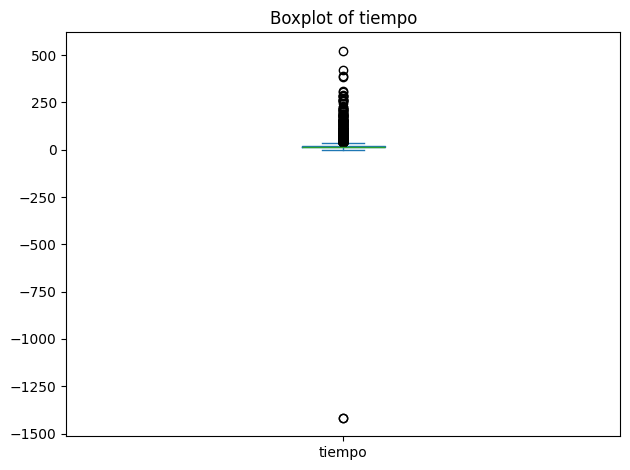

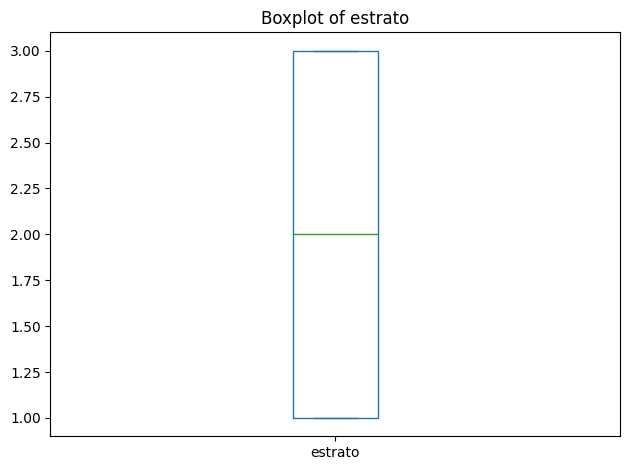

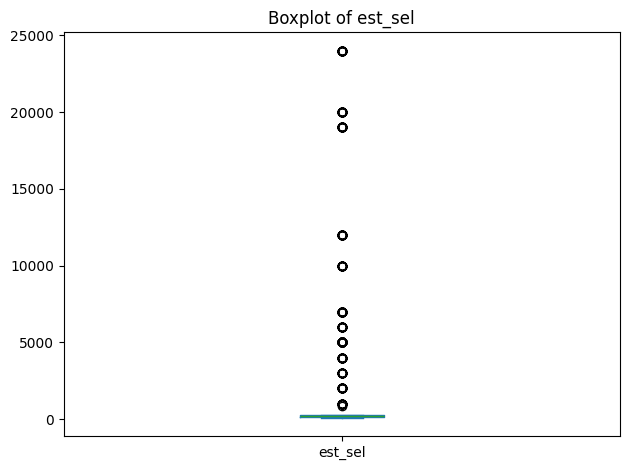

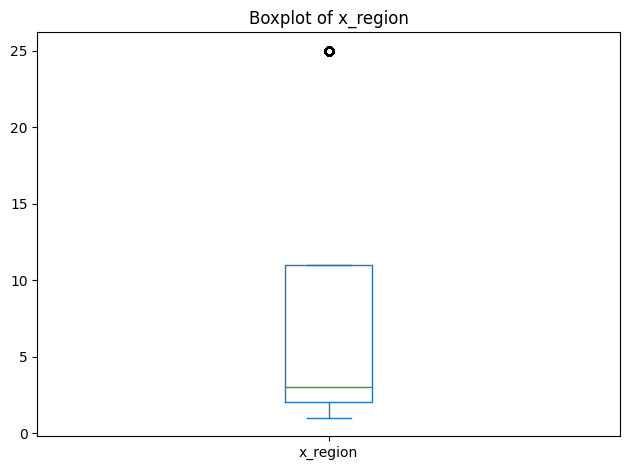

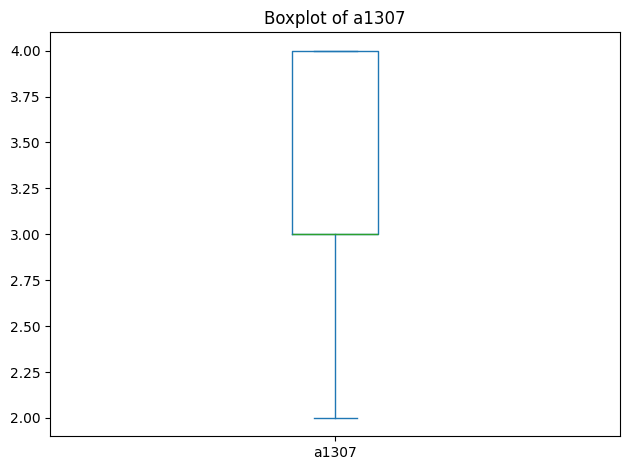

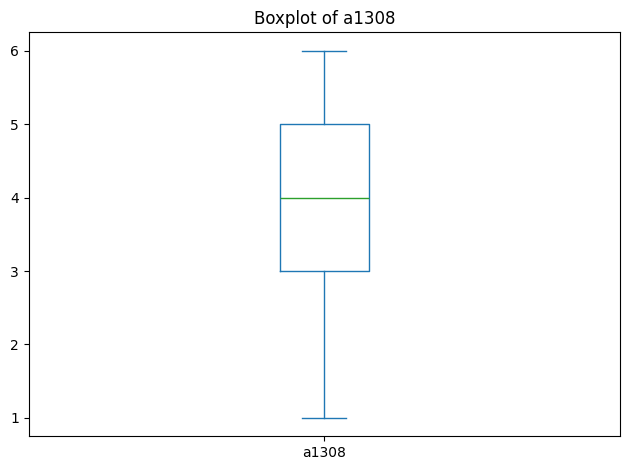

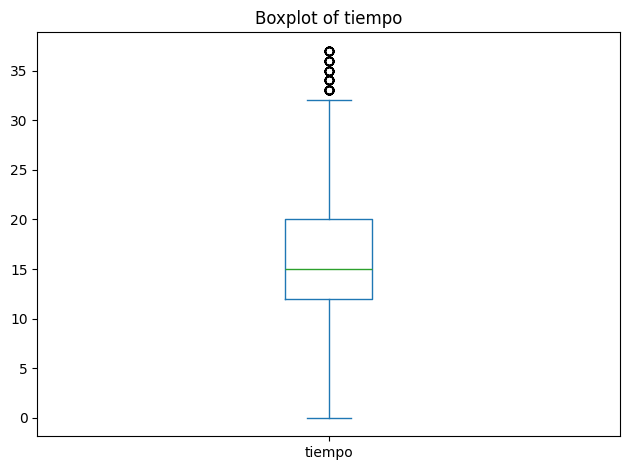

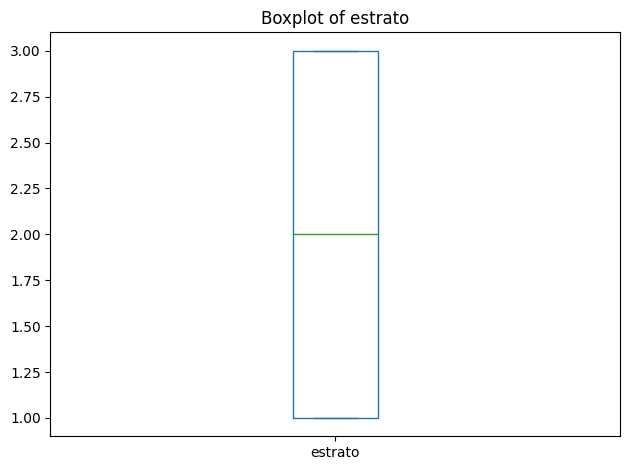

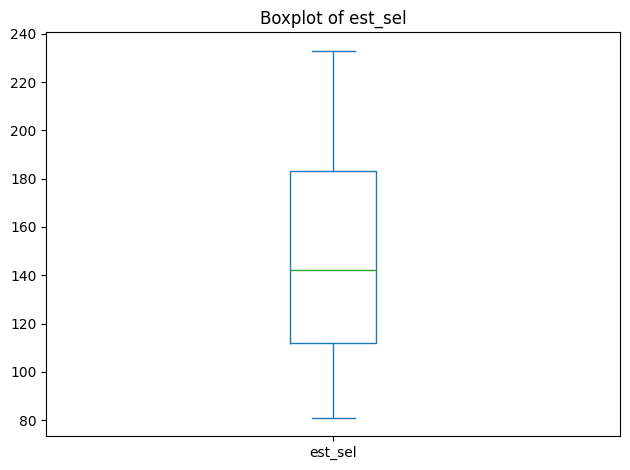

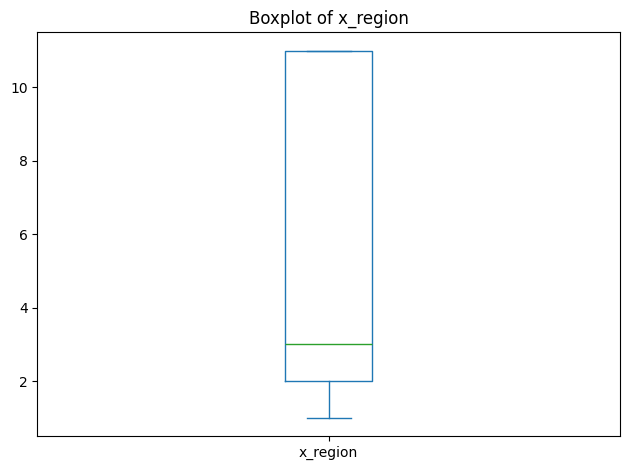

In [39]:
float_cols = df.select_dtypes(include=['float']).columns
for col in float_cols:
    df[[col]].plot(kind='box', title=f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

for col in float_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only rows where the value is within the bounds
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for col in float_cols:
    df[[col]].plot(kind='box', title=f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

***Normalise the float data***

In [48]:
df[float_cols] = (df[float_cols] - df[float_cols].min()) / (df[float_cols].max() - df[float_cols].min())

***Turn int data into categorical data***

In [57]:
int_cols = df.select_dtypes(include=['int']).columns

int_cols = df.select_dtypes(include='int').columns
df[int_cols] = df[int_cols].astype('category')

***Categorical data***


Apply phonetic blocking (spanish) to the dataset and the string comparision to find possible duplicates.

In [58]:
enc = PhoneticAlgorithmsES()

string_cols = [
    c for c in df.select_dtypes(include=["object", "string"]).columns
    if not c.endswith("_meta") and not c.endswith("_grouped")
]
n_rows = len(df)
threshold_unique = 0.1                      # mind. 10 % einzigartige Werte

phonetic_cols = {
    f"{c}_meta": df[c].apply(enc.spanish_metaphone)
    for c in string_cols
    if df[c].nunique() / n_rows > threshold_unique
}
df = df.assign(**phonetic_cols)

meta_cols = list(phonetic_cols.keys())
print("Phonetic columns:", meta_cols)

all_candidates = pd.MultiIndex(levels=[[], []], codes=[[], []])

for col in meta_cols:
    idx = recordlinkage.Index()
    idx.block(left_on=col)
    cand = idx.index(df)
    all_candidates = all_candidates.append(cand)

all_candidates = all_candidates.drop_duplicates()
print("Total candidates:", len(all_candidates))

compare = recordlinkage.Compare()
for col in string_cols:
    if f"{col}_meta" in meta_cols:          # nur auf encodete Spalten vergleichen
        compare.string(col, col, method="levenshtein", label=f"{col}_sim")

features = compare.compute(all_candidates, df)

threshold_sim = 0.6
high_pairs = features[features.min(axis=1) >= threshold_sim]
print("Highly similar pairs:", len(high_pairs))

groupings = {c: defaultdict(set) for c in string_cols}

for rec1, rec2 in high_pairs.index:
    for c in string_cols:
        v1, v2 = df.at[rec1, c], df.at[rec2, c]
        if v1 != v2:
            groupings[c][v1].update([v1, v2])

final_groups = {c: merge_groups(grp) for c, grp in groupings.items()}

grouped_df = pd.DataFrame({
    f"{c}_grouped": df[c].apply(lambda x: map_to_group(x, final_groups[c]))
    for c in string_cols
})
df = pd.concat([df, grouped_df], axis=1)
'''
for c in string_cols:
    df[f"{c}_grouped"] = df[c].apply(lambda x: map_to_group(x, final_groups[c]))
'''
grouped_cols = [f"{c}_grouped" for c in string_cols]
cols_to_keep = grouped_cols + [
    c for c in df.columns if c not in string_cols + meta_cols + grouped_cols
]
df = df[cols_to_keep].copy()

# Optional: _grouped‑Suffix abwerfen
df.rename(columns={gc: gc.replace("_grouped", "") for gc in grouped_cols}, inplace=True)

print("\nResult:")
print(df)

Phonetic columns: []
Total candidates: 0


ValueError: No objects to concatenate

Handle columns with too many unique values. Columns with two many unique values lead to some values only appearing very rarely. Due to these values appearing the model will usually not learn from these features due to there being a very small sample size of data points containing this categorical expression. If there are too many unique values in column, we will therefore choose to drop the column. Otherwise, we will group rarely occoring categories in the features together as "other" to reduce the complexity of the feature.

In [59]:

unique_counts = df.nunique().sort_values(ascending=False)

print(f"Unique values before cleaning: {unique_counts.head()}")

# Define threshold: if more than 90% of values are unique, drop
threshold = 0.9
n_rows = len(features)

high_card_cols = [
    col for col in df.columns
    if not pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() / n_rows > threshold
]

print("High-cardinality columns to drop:", high_card_cols)

# Drop them
df = df.drop(columns=high_card_cols)

# Drop rare categories in a column
df = group_rare_categories(df, threshold=0.01, placeholder="other")

unique_counts = df.nunique().sort_values(ascending=False)

print(f"Unique values after cleaning: {unique_counts.head()}")

# Chooses X% columns with the highest variance
percent = 20
if not (0 < percent <= 100):
    raise ValueError("Percent must be between 0 and 100 (exclusive of 0).")

# Select numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute variance
variances = numeric_df.var()

# Determine number of columns to keep
n_select = max(1, int(len(variances) * (percent / 100)))

# Get top columns by variance
top_columns = variances.sort_values(ascending=False).head(n_select).index

#Get the columns that are to be dropped
drop_col = variances.index.difference(top_columns)

#Drop the columns
df_rm = df.drop(columns=drop_col)
print(df_rm.shape)

Unique values before cleaning: fech_nac     3472
edad           76
aedad          76
municipio      71
tiempo1        38
dtype: int64
High-cardinality columns to drop: []
Unique values after cleaning: aedad        50
edad         49
tiempo       36
est_sel      34
municipio    31
dtype: int64
(3787, 25)


Remove columns with high entropy. This will likely also remove columns where the majority of feature values was transformed into 'other'

In [60]:
# --- Entropien berechnen ----------------------------------------------------
string_cols      = df.select_dtypes(include=['object', 'category', 'int'])
entropy_values   = string_cols.apply(compute_entropy).sort_values(ascending=False)

max_entropy_value = entropy_values.max()
max_entropy_col   = entropy_values.idxmax()

print("Spalte mit maximaler Entropie:", max_entropy_col)
print("Entropiewert:", max_entropy_value)

# --- Alle Spalten mit Entropie < 0.1 * Max drop­pen ------------------------
threshold = 0.1 * max_entropy_value
cols_to_drop = entropy_values[entropy_values < threshold].index.tolist()

print(f"\nDroppe {len(cols_to_drop)} Spalten (Entropie < {threshold:.4f}):")
print(cols_to_drop)

df = df.drop(columns=cols_to_drop)
print(df.shape)
dtype_counts = df.dtypes.value_counts()
print(f"Data types \n{dtype_counts}")

Spalte mit maximaler Entropie: aedad
Entropiewert: 5.506202705862696

Droppe 1 Spalten (Entropie < 0.5506):
['fech_nac']
(3787, 29)
Data types 
object      13
category     7
float64      6
category     1
category     1
category     1
Name: count, dtype: int64


**Post data cleaning inspection**

In [61]:
print(df.shape)

(3787, 29)


In [62]:
df.to_csv('cleaned_dataset.csv', index=False)